# **General Elections Classifier using BERT & DistilBERT**
---
### Pavlos Dais

# **Prerequisites**

In [1]:
!pip install transformers
!pip install (torch|tensorflow)
!pip install spacy
!python -m spacy download el_core_news_sm
!pip install optuna

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `pip install (torch|tensorflow)'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 79.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')


# **Import Libraries**

In [2]:
from transformers import BertModel, DistilBertModel, AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from tqdm.notebook import tqdm

import unicodedata

import pandas as pd
import numpy as np

# neural nets library
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import random

# used for metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import auc, roc_curve

# optimization
import torch.optim as optim

from nltk import FreqDist
from sklearn.preprocessing import label_binarize
from matplotlib import pyplot as plt
import re
import optuna
from gensim.models import KeyedVectors

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import label_binarize
from itertools import cycle
import logging

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

nltk.download("omw")
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('greek'))

# avoid error at data cleaning
pd.options.mode.chained_assignment = None

import spacy
from spacy.lang.el.examples import sentences 

from collections import Counter
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

nlp = spacy.load("el_core_news_sm")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to /usr/share/nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# define models and tokenizers
model_name        = "nlpaueb/bert-base-greek-uncased-v1"
tokenizer_b       = AutoTokenizer.from_pretrained(model_name)

model_name_distil = "EftychiaKarav/DistilGREEK-BERT"
tokenizer_distil  = AutoTokenizer.from_pretrained(model_name_distil)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [4]:
# use cuda, if possible
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f"Using {device}")

Using cuda


In [5]:
# set custom seed to make sure we get the same results in every run
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(0)

# **Useful Code for Analysis**


In [6]:
def show_most_common(data_a, common_words_num):
    # combine all text into a single string
    text = ' '.join(data_a['Text'])

    # generate word frequencies
    word_freq = pd.Series(text.lower().split()).value_counts()

    # plot the most common words
    word_freq.head(common_words_num).plot(kind='bar', rot=45)
    plt.title(f'Top {common_words_num} Most Common Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

# **Useful Code For Data Processing**

In [7]:
# emoji to text functionality
emoji_to_text = {
    "😃": "χαρα",
    "😢": "λυπη",
    "❤️": "καρδια",
    "👍": "συμφωνω",
    "👎": "διαφωνω"
}

# replace these vowels to remove accents
vowel_replacement = {
    'ά':'α',
    'έ':'ε',
    'ή':'η',
    'ί':'ι',
    'ό':'ο',
    'ύ':'υ',
    'ώ':'ω'
}

# my stop words (not included in the nltk library)
my_stop_words = ['ειναι', 'απο', 'οτι', 'μου', 'στις', 'μας', 'της', 'την', 'τον', 'τους', 'τη', 'το', 'στους', 'στα', 'σας', 'αυτο',
                'εχει', 'μια', 'ηταν', 'μια', 'σου', 'ενα', 'αυτος', 'εγω', 'σε', 'ενας', 'ειμαι', 'εχω', 'ο']

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def translate_greek(text):
    translation_table = str.maketrans (
        'abcdefghijklmnopqrstuvwxyz',
        'αβκδεφγηιξκλμνοπθρστυϐωχυζ'
    )
    return text.translate(translation_table)

# preprocesses the tweet
def clean_tweet(tweet_str):
    
    # remove hashtags
    tweet_str = re.sub(r'#\w+', '', tweet_str)
    
    # remove @'s
    tweet_str = re.sub(r'@(\w+)', '', tweet_str)
    
    # remove urls
    tweet_str = re.sub(r'http[s]?://\S+', '', tweet_str)
    
    # remove numbers & special characters
    tweet_str = re.sub(r'[0-9]|\W', ' ', tweet_str)
    
    # remove excess tabs & white spaces
    tweet_str = re.sub(r'\s+', ' ', tweet_str).strip()
    
    # convert to lowercase for generalization
    tweet_str = tweet_str.upper()
    tweet_str = tweet_str.lower()
    
    # remove stop words
    tweet_str = ' '.join([word for word in tweet_str.split(' ') if word not in stop_words])
    
    # translate english text
    tweet_str = translate_greek(tweet_str)
    
    # replace some emojies with a corresponding text and remove the rest
    for old_vowel, new_vowel in emoji_to_text.items():
        tweet_str = tweet_str.replace(old_vowel, new_vowel)
    tweet_str = re.sub(r'[\U00010000-\U0010ffff]', '', tweet_str)
    
    # lemmatization
    tweet_str = lemmatize_text(tweet_str)
    
    # remove accents
    for old_vowel, new_vowel in vowel_replacement.items(): tweet_str = tweet_str.replace(old_vowel, new_vowel)
    
    # remove my stop words
    tweet_str = ' '.join([word for word in tweet_str.split(' ') if word not in my_stop_words])
    
    return tweet_str

def clean_data(text):
    return text.apply(lambda x: x.map(clean_tweet))

def print_data(text, rows):
    for i in range(rows):
        print(text.iloc[i])

def append_word(cell_value):
    return cell_value + new_word
        
def get_data(data):        
    # extract the important piece of info
    X = data[['Text']]
    Y = data[['Sentiment']]
    parties = data[['Party']]

    clean_X = clean_data(X)
    
    # add political party at the start of the tweet
    # helps to know which political party the tweet is being referred to in the training process
    for i in range(len(clean_X)):
        political_party = parties.loc[i, 'Party']
        clean_X.loc[i, 'Text'] = str(political_party) + ' ' + clean_X.loc[i, 'Text']
    
    return clean_X, Y

def get_test_data(data):
    # extract the important piece of info
    X = data[['Text']]
    parties = data[['Party']]

    clean_X = clean_data(X)
    
    # add political party at the start of the tweet
    for i in range(len(clean_X)):
        political_party = parties.loc[i, 'Party']
        clean_X.loc[i, 'Text'] = str(political_party) + ' ' + clean_X.loc[i, 'Text']
    
    return clean_X

In [8]:
def sentences_to_sequences(sentences, max_length, token):
    """
    This function converts sentences into sequences of token IDs and generates corresponding attention masks.
    Parameters:
    - sentences (list): A list of sentences to be converted into sequences.
    - max_length (int): The maximum length of the sequences. Sentences will be truncated or padded to this length.
    - token (transformers.PreTrainedTokenizer): The tokenizer used for tokenizing the sentences.

    Returns:
    - input_ids_array (torch.Tensor): The tensor of sequences of token IDs.
    - attention_masks_array (torch.Tensor): The tensor of attention masks corresponding to the sequences.
    """
    
    # initialize arrays
    index                 = 0
    input_ids_array       = np.zeros((len(sentences), max_length)).astype(np.int32)
    attention_masks_array = np.zeros((len(sentences), max_length)).astype(np.int32)
    
    for sentence in sentences:
        # initialize arrays to store token IDs and attention mask for the current sentence
        sequence = np.zeros(max_length).astype(np.int32)             
        mask = np.zeros(max_length).astype(np.int32)                 
        
        # add special tokens ([CLS] and [SEP]) to the sentence as specified
        sentence = "[CLS] " + sentence + " [SEP]"                   
        
        # tokenize the sentence & convert tokens token IDs
        tokenized_sentence = token.tokenize(sentence)
        token_ids          = token.convert_tokens_to_ids(tokenized_sentence)  
        
        sequence_length = min(max_length, len(token_ids))
        
        # add token IDs to the sequence array
        sequence[:sequence_length] = np.array(token_ids[:sequence_length])
        
        # ensure the last token is [SEP] & set attention
        if sequence[sequence_length-1] != token.convert_tokens_to_ids('[SEP]'): sequence[sequence_length-1] = token.convert_tokens_to_ids('[SEP]')
        
        mask[:sequence_length] = np.array([1 for _ in range(sequence_length)])       
        
        # store the sequence and mask in the respective arrays
        input_ids_array[index]       = sequence
        attention_masks_array[index] = mask
        index += 1
    
    return torch.from_numpy(input_ids_array), torch.from_numpy(attention_masks_array)

# **Data Processing**

Before processing:


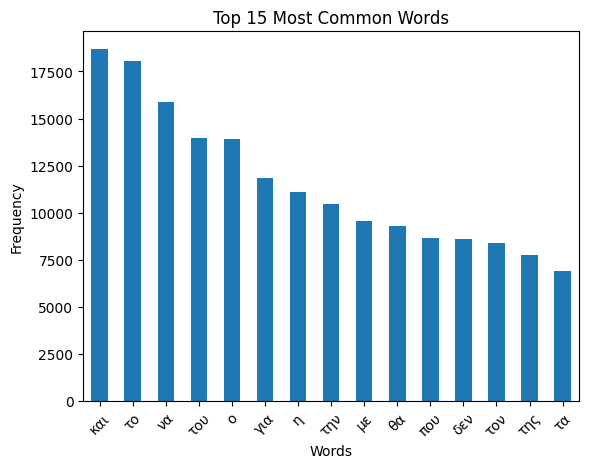

After processing:


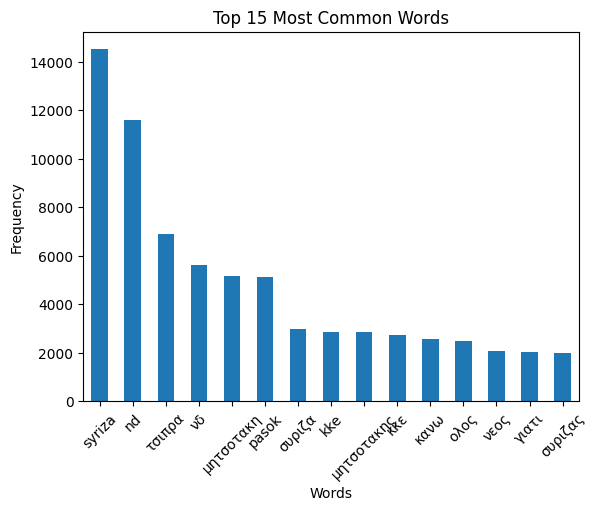

In [9]:
# read the dataframes
train_df = pd.read_csv("/kaggle/input/ys19-2023-assignment-4a/train_set.csv")
test_df  = pd.read_csv("/kaggle/input/ys19-2023-assignment-4a/valid_set.csv")

# plot this many number of words
common_words_num = 15

print("Before processing:")
show_most_common(train_df, common_words_num)

# convert it
train_data = get_data(train_df)
test_data  = get_data(test_df)

print("After processing:")
show_most_common(train_data[0], common_words_num)

# **Convert data**

In [10]:
# get x values
x_train, y_train           = train_data
x_validation, y_validation = test_data

train_sentences = [sentence for sentence in x_train['Text']]
val_sentences   = [sentence for sentence in x_validation['Text']]

In [11]:
max_length = 45
batch_size = 50

# get y values
label_mapping     = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
label_mapping_rev = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']


y_train      = train_df[['Sentiment']]
y_validation = test_df[['Sentiment']]

y_train['Sentiment'] = y_train['Sentiment'].map(label_mapping)
y_train              = torch.tensor(y_train.values, dtype=torch.long)
y_train              = y_train.view(-1)

y_validation['Sentiment'] = y_validation['Sentiment'].map(label_mapping)
y_validation              = torch.tensor(y_validation.values, dtype=torch.long)
y_validation              = y_validation.view(-1)

In [12]:
# tokenize for bert
x_tr_bert  = sentences_to_sequences(train_sentences, max_length, tokenizer_b)
x_val_bert = sentences_to_sequences(val_sentences, max_length, tokenizer_b)

train_dataset      = torch.utils.data.TensorDataset(x_tr_bert[0], x_tr_bert[1], y_train)
val_dataset        = torch.utils.data.TensorDataset(x_val_bert[0], x_val_bert[1], y_validation)

train_dataloader_b = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader_b   = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True)

# (finally) pack training, validation data together
train_bert       = (x_tr_bert, y_train)
validation_bert  = (x_val_bert, y_validation)

In [13]:
# tokenize for distil
x_tr_distil  = sentences_to_sequences(train_sentences, max_length, tokenizer_distil)
x_val_distil = sentences_to_sequences(val_sentences, max_length, tokenizer_distil)

train_dataset = torch.utils.data.TensorDataset(x_tr_distil[0], x_tr_distil[1], y_train)
val_dataset   = torch.utils.data.TensorDataset(x_val_distil[0], x_val_distil[1], y_validation)

train_dataloader_distil = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader_distil   = torch.utils.data.DataLoader(val_dataset,   batch_size=batch_size, shuffle=True)

# (finally) pack training, validation data together
train_distil      = (x_tr_distil, y_train) 
validation_distil = (x_val_distil, y_validation)

In [14]:
def extract_batch(batch):
    return batch[0].to(device), batch[1].to(device), batch[2].to(device)

def calculate_pred(model, y_pred, y_batch, loss, batch_losses, batch_scores):
    batch_losses.append(loss.item())
    proba  = F.softmax(y_pred, dim=1)
    y_pred = proba.argmax(dim=1)
    batch_scores.append(f1_score(y_batch.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), average='weighted'))
    
# the number of epochs allowed with no improvements
epoch_limit = 2
def train_model(train_data, val_data, model, loss_function, optimizer, batch_size, epochs_num, clip_grad, tr_dataloader, v_dataloader):
    """
    This function trains a pytorch model on a specific number of epochs and batch size.
    Parameters:
    - train_data (tuple): The train data(x,y).
    - val_data (tuple): The validation data(x,y).
    - model: The model we will be training.
    - loss_function: The loss function we will be using during training.
    - optimizer: The optimizer we will be using during training.
    - batch_size: The number of batches our data we will be divided into.
    - epochs_num(int): The number of epochs that will take place.
    - clip_grad(bool): Whether to perform gradient clippint or not.
    - tr_dataloader: The training dataloader.
    - v_dataloader: The validation dataloader.

    Returns:
    The fscore, loss values for both train and validation data. More specifically: 
    training scores (list), training losses (list), validation scores (list), validation losses (list), epochs (list), model
    """
    
    # extract train/ validation data
    x_tr, y_tr   = train_data
    x_val, y_val = val_data

    # save fscore/loss values
    tr_scores  = list()
    tr_losses  = list()
    val_scores = list()
    val_losses = list()
    
    min_val_loss = np.Inf
    num_of_epochs = epochs_not_improved = 0

    for epoch in range(epochs_num):
        # store batch training & validation scores/losses
        batch_scores_train = list()
        batch_losses_train = list()
        batch_scores_val   = list()
        batch_losses_val   = list()
        
        # current epoch train
        model.train()
        
        progress_loop = tqdm(tr_dataloader, leave=True)
        for train_batch in progress_loop:
            x_batch, masks, y_batch = extract_batch(train_batch)
            
            # reset old gradients and forward pass
            optimizer.zero_grad()
            
            y_pred = model(x_batch, attention_mask=masks)
            
            # calculate scores
            loss = loss_function(y_pred, y_batch)
            calculate_pred(model, y_pred, y_batch, loss, batch_losses_train, batch_scores_train)
            
            # backpropagate using this epoch's loss
            # then update the weights
            loss.backward()
            if clip_grad: nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            
            optimizer.step()
            
            # update progress loop
            progress_loop.set_description(f'[Epoch {epoch+1}]')
            progress_loop.set_postfix(loss=loss.item())
        
        # update (training) scores
        tr_losses.append(sum(batch_losses_train)/len(tr_dataloader))
        tr_scores.append(sum(batch_scores_train)/len(tr_dataloader))
        
        # get validation scores
        model.eval()
        for val_batch in v_dataloader:
            x_batch, masks, y_batch = extract_batch(val_batch)
            
            with torch.no_grad(): y_pred = model(x_batch, attention_mask=masks)
            
            calculate_pred(model, y_pred, y_batch, loss_function(y_pred, y_batch), batch_losses_val, batch_scores_val)
        
        # update (validation) scores
        val_losses.append(sum(batch_losses_val)/len(v_dataloader))
        val_scores.append(sum(batch_scores_val)/len(v_dataloader))
        
        curr_loss = tr_losses[-1]
        print(f'\r[Epoch {epoch+1}/{epochs_num}] Train Loss: {curr_loss:0.4f} / Validation Loss: {val_losses[-1]:0.4f}')
        
        # early stopping: if no improvements (for <epoch_limit> times) have been made exit
        num_of_epochs += 1
        if (curr_loss < min_val_loss):
            min_val_loss = curr_loss
            epochs_not_improved = 0
        else: epochs_not_improved+=1
        
        if (epochs_not_improved == epoch_limit):
            print("Activated early stopping")
            break
    
    return tr_scores, tr_losses, val_scores, val_losses, [epoch for epoch in range(num_of_epochs)], model

In [15]:
def pscores(y_true, y_pred, train_set):
    """
    This function prints the precision, recall, and F1 score for the given true and predicted labels.

    Parameters:
    - y_true: The true class labels.
    - y_pred: The predicted labels.
    - train_set (bool): A flag indicating whether the data is a training set or a validation set.

    Returns: Nothing.
    """
    if train_set: print("Τraining set:")
    else:         print("Validation set:")
    
    # show average scores
    precision = precision_score(y_true, y_pred, average='weighted')
    recall    = recall_score(y_true, y_pred, average='weighted')
    score     = f1_score(y_true, y_pred, average='weighted')

    print(f"\n[Weighted average] Precision = {precision}")
    print(f"[Weighted average] Recall    = {recall}")
    print(f"[Weighted average] Fscore    = {score}\n")
    
    # show scores per class
    precision = precision_score(y_true, y_pred, average=None)
    recall    = recall_score(y_true, y_pred, average=None)
    score     = f1_score(y_true, y_pred, average=None)

    for i in range(score.shape[0]):
        print(f"[{label_mapping_rev[i]} Class] Precision = {precision[i]}")
        print(f"[{label_mapping_rev[i]} Class] Recall = {recall[i]}")
        print(f"[{label_mapping_rev[i]} Class] Fscore = {score[i]}\n")
    print("\n")

def plot_results(epochs, train_scores, validation_scores, train_losses, validation_losses, y_true, y_pred, label):
    """
    This function plots the results of training (f1 score, loss learning, ROC curve).
    Parameters:
    - epochs (list): A list containing the epochs used during training.
    - train_scores (list): The train fscores during each epoch.
    - validation_scores (list): The validation scores during each epo
    - train_losses (list): The train losses during each epoch.
    - validation_losses (list): The validation losses during each epoch.
    - y_true (tensor): The actual labels.
    - y_pred (tensor): The predicited labels.
    - label (string): The title of the graph.
    Returns: Nothing
    """
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # plot f1 score
    ax1 = axes[0]
    ax1.plot(epochs, train_scores, label="Training Score")
    ax1.plot(epochs, validation_scores, label="Validation Score")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("FScore")
    ax1.legend()
    ax1.set_title("Fscore Learning Curve")
    
    # plot cross-entropy loss
    ax2 = axes[1]
    ax2.plot(epochs, train_losses, label="Training Loss")
    ax2.plot(epochs, validation_losses, label="Validation Loss")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Cross-Entropy Loss")
    ax2.legend()
    ax2.set_title("Loss Learning Curve")

    # plot ROC curves
    ax3 = axes[2]
    y_test = label_binarize(y_true, classes = [0, 1, 2])
    y_score = y_pred
    n_classes = 3

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # plotting ROC curves side by side
    ax3.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})'''.format(roc_auc["micro"]))

    for i in range(n_classes):
        ax3.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'''.format({label_mapping_rev[i]}, roc_auc[i]))
    
    ax3.plot([0, 1], [0, 1], 'k--')
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylabel('True Positive Rate')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_title('ROC all classes')
    ax3.legend(loc="lower right")
    
    fig.suptitle(label, fontsize=16)
    plt.tight_layout()
    plt.show()

In [16]:
def calculate_scores(model, dataloader):
    """
    This function calculates the true labels, predicted labels, and probabilities of predictions for a model and dataloader.
    Parameters:
    - model (torch.nn.Module): The model used for prediction.
    - dataloader (torch.utils.data.DataLoader): The DataLoader object containing the dataset for which predictions are to be made.

    Returns:
    - true_labels (numpy.ndarray): The actual labels of the data.
    - pred_labels (numpy.ndarray): The predicted labels by the model.
    - y_probs (numpy.ndarray): The probabilities of each prediction.
    """
    y       = list()
    y_hat   = list()
    y_probs = list()
    for batch in dataloader:
        x_batch, masks, y_batch = extract_batch(batch)
        
        with torch.no_grad(): y_pred = model(x_batch, attention_mask=masks)
        
        probs = F.softmax(y_pred, dim=1)
        y_label_pred = probs.argmax(dim=1)
        y.append(y_batch)
        y_hat.append(y_label_pred)
        y_probs.append(probs)

    true_labels = torch.cat(y, dim=0)
    pred_labels = torch.cat(y_hat, dim=0)
    y_probs     = torch.cat(y_probs, dim=0)
    
    return true_labels.detach().cpu().numpy(), pred_labels.detach().cpu().numpy(), y_probs
                         
def model_results(model, x_train, y_train, x_val, y_val, epochs, train_scores, val_scores, train_losses, val_losses, label, tr_dl, val_dl):
    """
    This function prints the scores of both the training sets and the validation set.
    """
    model.eval()
    
    # show scores for training set
    true_labels, pred_labels, _ = calculate_scores(model, tr_dl)
    pscores(true_labels, pred_labels, True)
    
    # show scores for validation set
    true_labels, pred_labels, y_probs = calculate_scores(model, val_dl)
    pscores(true_labels, pred_labels, False)
    
    # show curves
    plot_results(epochs, train_scores, val_scores, train_losses, val_losses, true_labels, y_probs.detach().cpu().numpy(), label)

def make_predictions(model, sentences, tokenizer):
    """
    This function makes predictions for a given set of sentences using a specified model and tokenizer.
    Parameters:
    - model (torch.nn.Module): The model used for prediction.
    - sentences (list): A list of sentences for which predictions are to be made.
    - tokenizer (transformers.PreTrainedTokenizer): The tokenizer used for tokenizing the sentences.

    Returns:
    - y_pred_list (numpy.ndarray): The predictions made by the model for the input sentences.
    """
    x_test, attention_masks = sentences_to_sequences(sentences, max_length, tokenizer)

    x_test          = x_test.to(device)
    attention_masks = attention_masks.to(device)
    
    test_dataset    = torch.utils.data.TensorDataset(x_test, attention_masks)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    
    y_pred_list = list()
    model.eval()
    
    with torch.no_grad():
        for batch in test_dataloader:
            b_input_ids, b_input_mask = batch
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)

            y_pred = model(b_input_ids, attention_mask=b_input_mask)
            y_pred = y_pred.detach().cpu().numpy()
            y_pred_list.append(y_pred)

            # move tensors to CPU
            b_input_ids = b_input_ids.cpu()
            b_input_mask = b_input_mask.cpu()

    return np.concatenate(y_pred_list, axis=0)

# **Model Definition**
Here I'll be defining the Bert & DistilBert models.

# Bert

In [17]:
class BertDropout(nn.Module):
    def __init__(self, n_classes, dropout, pretrained_model=model_name):
        super(BertDropout, self).__init__()
        
        # bert model
        self.bert_l  = BertModel.from_pretrained(pretrained_model, return_dict=False)
        
        # dropout layer
        self.dropout = nn.Dropout(p=dropout)
        
        # output layer
        self.out     = nn.Linear(self.bert_l.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        _, output = self.bert_l(input_ids=input_ids, attention_mask=attention_mask)
        output    = self.dropout(output)
        output    = self.out(output)
        return self.softmax(output)

# DistilBert

In [18]:
class DistilBertDropout(nn.Module):
    def __init__(self, n_classes, dropout, pretrained_model=model_name_distil):
        super(DistilBertDropout, self).__init__()
        
        # distilbert model
        self.distilbert_l  = DistilBertModel.from_pretrained(pretrained_model, return_dict=False)
        
        # dropout layer
        self.dropout = nn.Dropout(p=dropout)
        
        # output layer
        self.out     = nn.Linear(self.distilbert_l.config.dim, n_classes)

    def forward(self, input_ids, attention_mask):
        output = self.distilbert_l(input_ids=input_ids, attention_mask=attention_mask)[0]
        
        # take the mean across the sequence_length dimension
        output = output.mean(dim=1)
        output = self.dropout(output)
        output = self.out(output)
        return output

# **Model 1: Bert with the default hyperparameters**

pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 1/3] Train Loss: 1.0912 / Validation Loss: 1.0748


  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 2/3] Train Loss: 1.0717 / Validation Loss: 1.0631


  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 3/3] Train Loss: 1.0552 / Validation Loss: 1.0673
Τraining set:

[Weighted average] Precision = 0.5106984339473665
[Weighted average] Recall    = 0.4745017745017745
[Weighted average] Fscore    = 0.46561602623117615

[NEGATIVE Class] Precision = 0.4699368211826507
[NEGATIVE Class] Recall = 0.5421785421785422
[NEGATIVE Class] Fscore = 0.5034794843518273

[NEUTRAL Class] Precision = 0.42496171516079634
[NEUTRAL Class] Recall = 0.5909090909090909
[NEUTRAL Class] Fscore = 0.4943812525695492

[POSITIVE Class] Precision = 0.6371967654986523
[POSITIVE Class] Recall = 0.29041769041769044
[POSITIVE Class] Fscore = 0.3989873417721519



Validation set:

[Weighted average] Precision = 0.4377136139478403
[Weighted average] Recall    = 0.41494648318042815
[Weighted average] Fscore    = 0.4025035414255345

[NEGATIVE Class] Precision = 0.41287128712871285
[NEGATIVE Class] Recall = 0.4782110091743119
[NEGATIVE Class] Fscore = 0.44314558979808716

[NEUTRAL Class] Precision = 0.3852760736196319
[

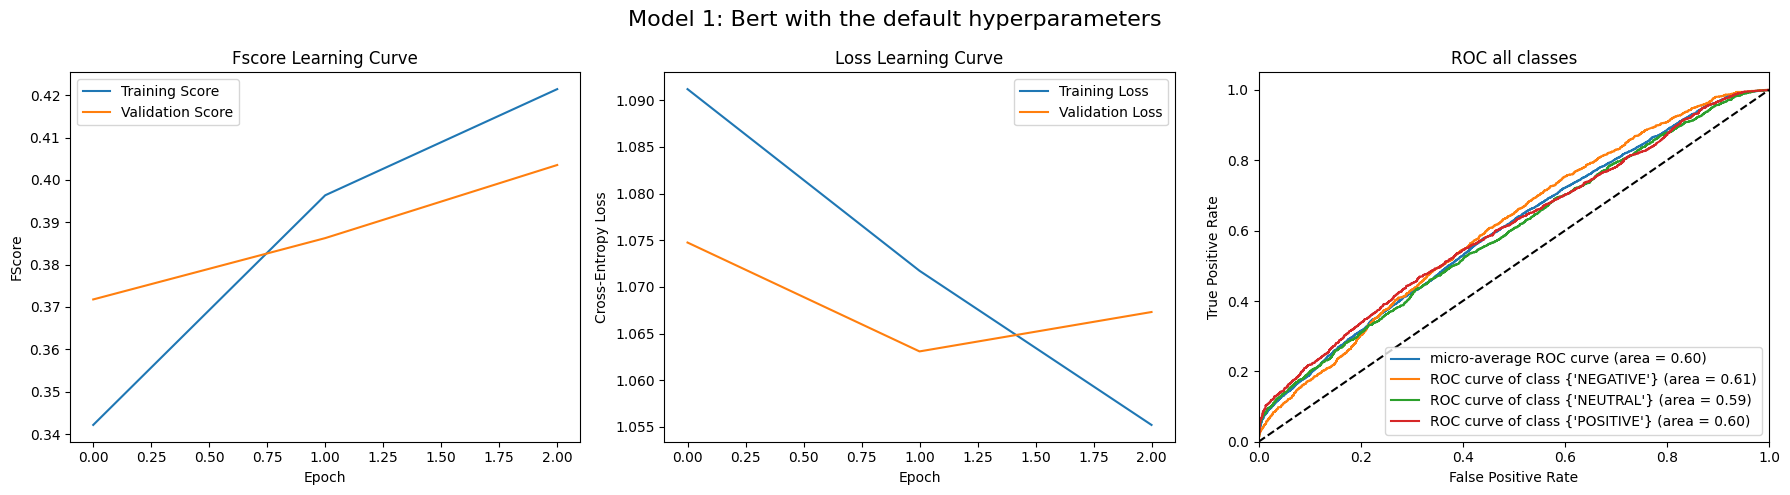

In [19]:
dropout_n = 0.3

bert_model = BertDropout(n_classes=3, dropout=dropout_n)
bert_model.to(device)

num_epochs       = 3
learning_rate    = 3e-5
clip_g           = True
criterion        = nn.CrossEntropyLoss()
optimizer        = torch.optim.AdamW(bert_model.parameters(), lr=learning_rate)
train_dataloader = train_dataloader_b
val_dataloader   = val_dataloader_b

# train model
tr_scores, tr_losses, val_scores, val_losses, epochs, bert_model = train_model(
    train_bert, validation_bert, bert_model, criterion, optimizer, batch_size, num_epochs, clip_g, train_dataloader_b, val_dataloader_b)

# show results
model_results(bert_model, x_tr_bert, y_train, x_val_bert, y_validation, epochs, tr_scores, val_scores, tr_losses, val_losses,
               "Model 1: Bert with the default hyperparameters", train_dataloader_b, val_dataloader_b)

# **Model 2: DistilBert with the default hyperparameters**

config.json:   0%|          | 0.00/540 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/282M [00:00<?, ?B/s]

  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 1/3] Train Loss: 1.1199 / Validation Loss: 1.0907


  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 2/3] Train Loss: 1.1001 / Validation Loss: 1.0830


  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 3/3] Train Loss: 1.0864 / Validation Loss: 1.0684
Τraining set:

[Weighted average] Precision = 0.418608490628444
[Weighted average] Recall    = 0.40819000819000817
[Weighted average] Fscore    = 0.3866264001966032

[NEGATIVE Class] Precision = 0.4018878539726199
[NEGATIVE Class] Recall = 0.5265356265356266
[NEGATIVE Class] Fscore = 0.45584429396958204

[NEUTRAL Class] Precision = 0.45210229735587343
[NEUTRAL Class] Recall = 0.17084357084357085
[NEUTRAL Class] Fscore = 0.24797907750832143

[POSITIVE Class] Precision = 0.40183532055683874
[POSITIVE Class] Recall = 0.5271908271908272
[POSITIVE Class] Fscore = 0.4560558291119062



Validation set:

[Weighted average] Precision = 0.4177344325920243
[Weighted average] Recall    = 0.4032874617737003
[Weighted average] Fscore    = 0.38269480952250434

[NEGATIVE Class] Precision = 0.3926218708827404
[NEGATIVE Class] Recall = 0.5126146788990825
[NEGATIVE Class] Fscore = 0.4446655060930117

[NEUTRAL Class] Precision = 0.4637904468412943
[

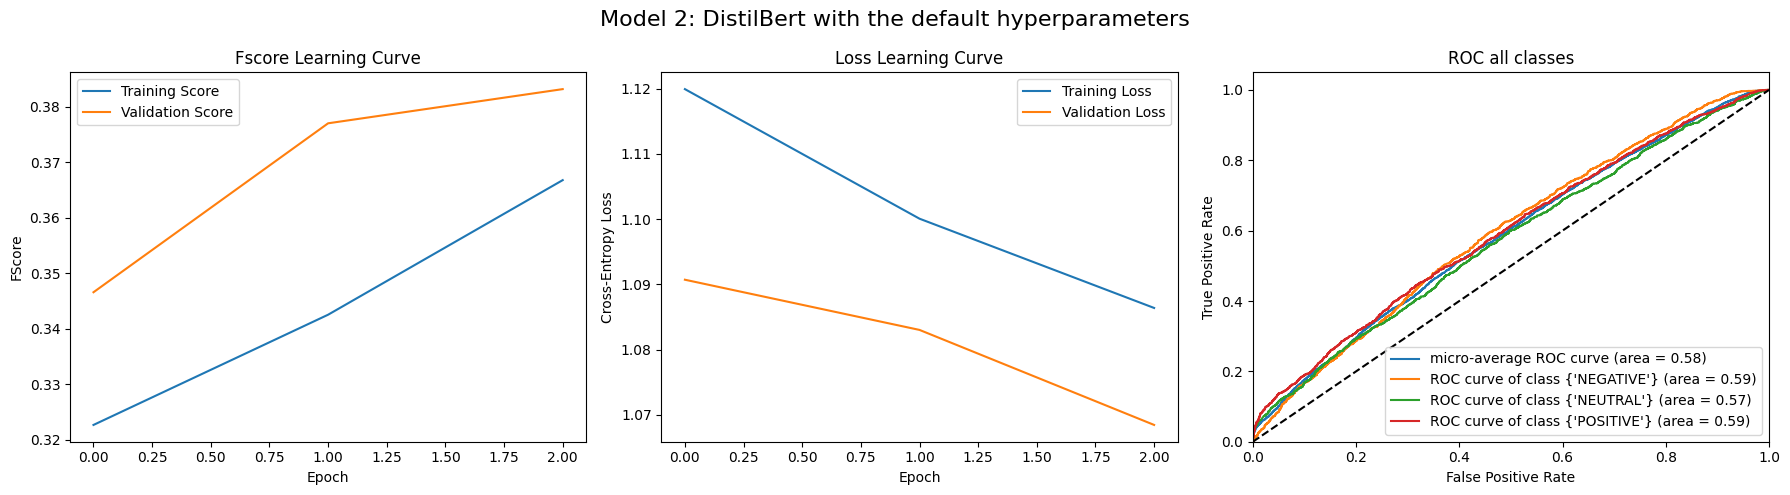

In [20]:
dropout_n = 0.3

distil_model = DistilBertDropout(n_classes=3, dropout=dropout_n)
distil_model.to(device)

num_epochs       = 3
learning_rate    = 3e-5
clip_g           = True
criterion        = nn.CrossEntropyLoss()
optimizer        = torch.optim.AdamW(distil_model.parameters(), lr=learning_rate)
train_dataloader = train_dataloader_distil
val_dataloader   = val_dataloader_distil

# train model
tr_scores, tr_losses, val_scores, val_losses, epochs, distil_model = train_model(
    train_distil, validation_distil, distil_model, criterion, optimizer, batch_size, num_epochs, clip_g, train_dataloader_distil, val_dataloader_distil)

# show results
model_results(distil_model, x_tr_distil, y_train, x_val_distil, y_validation, epochs, tr_scores, val_scores, tr_losses, val_losses,
               "Model 2: DistilBert with the default hyperparameters", train_dataloader_distil, val_dataloader_distil)

# **Optuna**

In [21]:
# default hyperparemeters settings
num_epochs     = 3
dropout_range  = None
learning_range = None
clip_g         = True
bert           = True

def objective(trial):
    # dropout probability
    dropout_rate = trial.suggest_float('dropout_rate', dropout_range[0], dropout_range[1])
    
    # build the model [either bert or DistilBert]
    optuna_model     = None
    train_data       = None
    val_data         = None
    train_dataloader = None
    val_dataloader   = None
    x_tr             = None
    
    if (bert):
        train_dataloader = train_dataloader_b
        val_dataloader   = val_dataloader_b
        train_data       = train_bert
        val_data         = validation_bert
        x_tr             = (x_tr_bert, x_val_bert)
        optuna_model     = BertDropout(n_classes=3, dropout=dropout_rate)
    else:
        train_dataloader = train_dataloader_distil
        val_dataloader   = val_dataloader_distil
        train_data       = train_distil
        val_data         = validation_distil
        x_tr             = (x_tr_distil, x_val_distil)
        optuna_model     = DistilBertDropout(n_classes=3, dropout=dropout_rate)
    
    optuna_model.to(device)
    
    # learning rate
    criterion     = nn.CrossEntropyLoss()
    learning_rate = trial.suggest_float('learning_rate', learning_range[0], learning_range[1])
    optimizer     = torch.optim.AdamW(optuna_model.parameters(), lr=learning_rate)

    # train model
    tr_scores, tr_losses, val_scores, val_losses, epochs, optuna_model = train_model(
        train_data, val_data, optuna_model, criterion, optimizer, batch_size, num_epochs, clip_g, train_dataloader, val_dataloader)
    
    # show results
    model_results(optuna_model, x_tr[0], y_train, x_tr[1], y_validation, epochs, tr_scores, val_scores, tr_losses,
                  val_losses, "Optuna", train_dataloader, val_dataloader)
    
    true_labels, pred_labels, _ = calculate_scores(optuna_model, train_dataloader)
    return f1_score(true_labels, pred_labels, average='weighted')

# **Optuna: GreekBERT**
I'll be running hyperparameter optimization on the GreekBert model.

## **Run 1**

  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 1/3] Train Loss: 1.0908 / Validation Loss: 1.0703


  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 2/3] Train Loss: 1.0708 / Validation Loss: 1.0703


  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 3/3] Train Loss: 1.0605 / Validation Loss: 1.0653
Τraining set:

[Weighted average] Precision = 0.4917536951973268
[Weighted average] Recall    = 0.46306306306306305
[Weighted average] Fscore    = 0.43873755543548765

[NEGATIVE Class] Precision = 0.4426138876603273
[NEGATIVE Class] Recall = 0.6556920556920557
[NEGATIVE Class] Fscore = 0.5284837282988976

[NEUTRAL Class] Precision = 0.5773342836778332
[NEUTRAL Class] Recall = 0.19901719901719903
[NEUTRAL Class] Fscore = 0.29599853827882333

[POSITIVE Class] Precision = 0.45531291425381987
[POSITIVE Class] Recall = 0.5344799344799345
[POSITIVE Class] Fscore = 0.491730399728742



Validation set:

[Weighted average] Precision = 0.4329110491993767
[Weighted average] Recall    = 0.41628440366972475
[Weighted average] Fscore    = 0.39119584646256034

[NEGATIVE Class] Precision = 0.3977186311787072
[NEGATIVE Class] Recall = 0.5997706422018348
[NEGATIVE Class] Fscore = 0.47828074988568814

[NEUTRAL Class] Precision = 0.4789915966386555


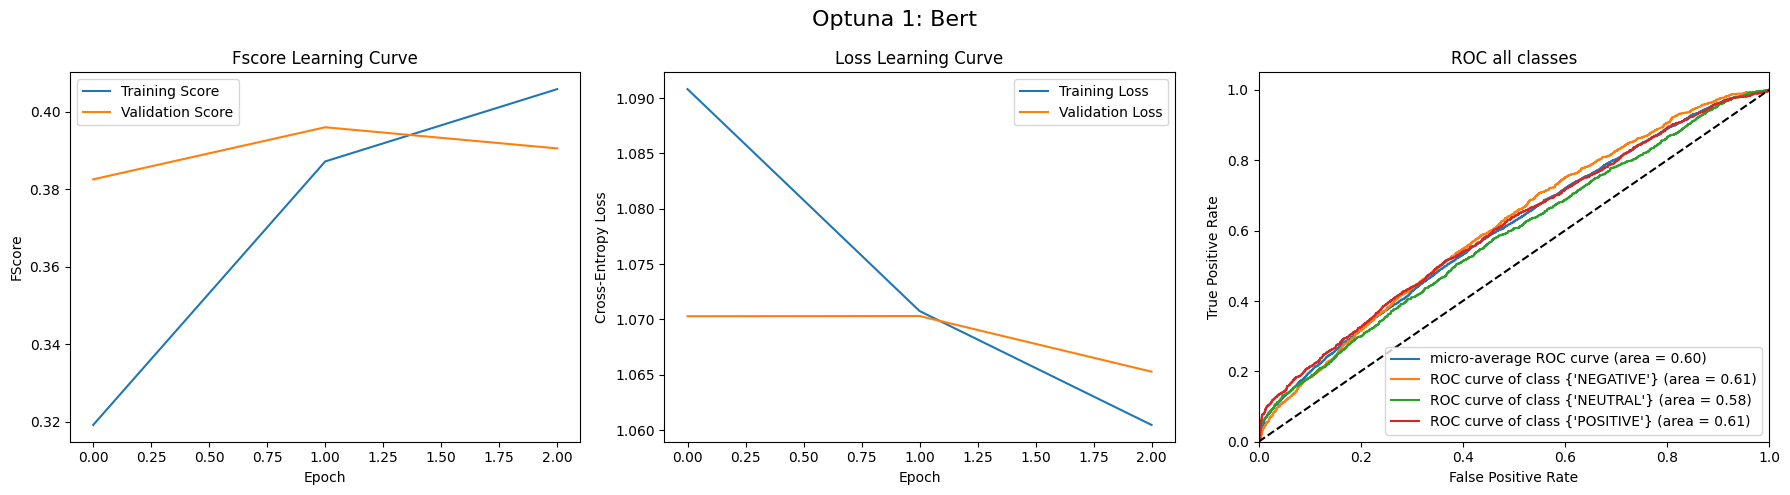

In [22]:
#learning_range = [2e-5, 5e-05]
#dropout_range  = [0, 0.5]
#bert           = True
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=32)
#best_params = study.best_params
#print(f"Best Hyperparameters: {best_params}")

#################################################################

dropout_n = 0.011051848595193536

bert_model = BertDropout(n_classes=3, dropout=dropout_n)
bert_model.to(device)

num_epochs       = 3
learning_rate    = 3.827331440110047e-05
clip_g           = True
criterion        = nn.CrossEntropyLoss()
optimizer        = torch.optim.AdamW(bert_model.parameters(), lr=learning_rate)
train_dataloader = train_dataloader_b
val_dataloader   = val_dataloader_b

# train model
tr_scores, tr_losses, val_scores, val_losses, epochs, bert_model = train_model(
    train_bert, validation_bert, bert_model, criterion, optimizer, batch_size, num_epochs, clip_g, train_dataloader_b, val_dataloader_b)

# show results
model_results(bert_model, x_tr_bert, y_train, x_val_bert, y_validation, epochs, tr_scores, val_scores, tr_losses, val_losses,
               "Optuna 1: Bert", train_dataloader_b, val_dataloader_b)

## **Run 2**

  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 1/3] Train Loss: 1.0917 / Validation Loss: 1.0761


  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 2/3] Train Loss: 1.0714 / Validation Loss: 1.0676


  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 3/3] Train Loss: 1.0555 / Validation Loss: 1.0620
Τraining set:

[Weighted average] Precision = 0.49248680850400184
[Weighted average] Recall    = 0.48891618891618893
[Weighted average] Fscore    = 0.48356755580531857

[NEGATIVE Class] Precision = 0.4952715288723313
[NEGATIVE Class] Recall = 0.5661752661752661
[NEGATIVE Class] Fscore = 0.5283552430449403

[NEUTRAL Class] Precision = 0.5138520838352204
[NEUTRAL Class] Recall = 0.3493857493857494
[NEUTRAL Class] Fscore = 0.41595163806552266

[POSITIVE Class] Precision = 0.4683368128044537
[POSITIVE Class] Recall = 0.5511875511875511
[POSITIVE Class] Fscore = 0.5063957863054929



Validation set:

[Weighted average] Precision = 0.4315181719858458
[Weighted average] Recall    = 0.4271788990825688
[Weighted average] Fscore    = 0.4220312415361992

[NEGATIVE Class] Precision = 0.4136919315403423
[NEGATIVE Class] Recall = 0.48509174311926606
[NEGATIVE Class] Fscore = 0.4465558194774347

[NEUTRAL Class] Precision = 0.45676855895196505
[

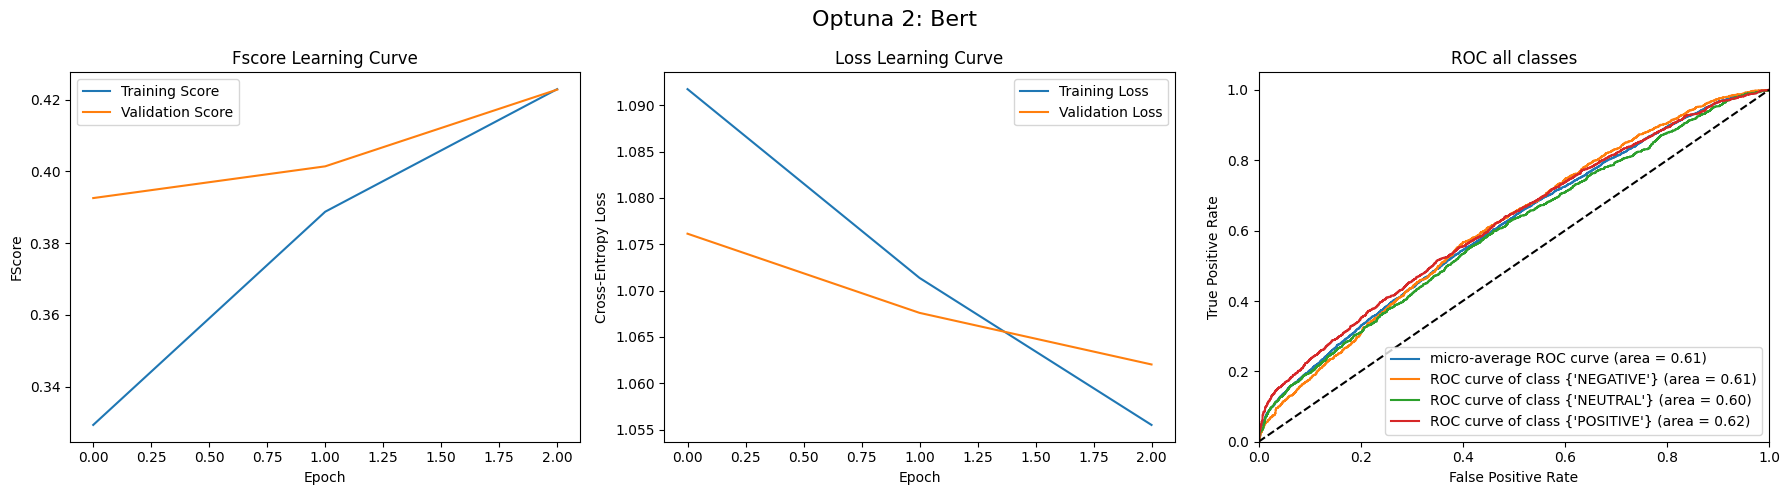

In [23]:
# after the first run I conclude that the best learning rate range is at [2e-5, 4.5e-05]
# and the best droupout range is at [0.041, 0.15]

#learning_range = [2e-5, 4.5e-05]
#dropout_range  = [0.041, 0.15]
#bert           = True
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=32)
#best_params = study.best_params
#print(f"Best Hyperparameters: {best_params}")

#################################################################

dropout_n = 0.14388971001431713

bert_model = BertDropout(n_classes=3, dropout=dropout_n)
bert_model.to(device)

num_epochs       = 3
learning_rate    = 3.209545757270892e-05
clip_g           = True
criterion        = nn.CrossEntropyLoss()
optimizer        = torch.optim.AdamW(bert_model.parameters(), lr=learning_rate)
train_dataloader = train_dataloader_b
val_dataloader   = val_dataloader_b

# train model
tr_scores_b, tr_losses_b, val_scores_b, val_losses_b, epochs_b, bert_model = train_model(
    train_bert, validation_bert, bert_model, criterion, optimizer, batch_size, num_epochs, clip_g, train_dataloader_b, val_dataloader_b)

# show results
model_results(bert_model, x_tr_bert, y_train, x_val_bert, y_validation, epochs_b, tr_scores_b, val_scores_b, tr_losses_b, val_losses_b,
               "Optuna 2: Bert", train_dataloader_b, val_dataloader_b)

# **Optuna: DistilGREEK-BERT**
I'll be running hyperparameter optimization on the GreekBert model.

## **Run 1**

  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 1/3] Train Loss: 1.1051 / Validation Loss: 1.0869


  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 2/3] Train Loss: 1.0916 / Validation Loss: 1.0825


  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 3/3] Train Loss: 1.0783 / Validation Loss: 1.0714
Τraining set:

[Weighted average] Precision = 0.4419171667782198
[Weighted average] Recall    = 0.41094731094731096
[Weighted average] Fscore    = 0.3819838133652012

[NEGATIVE Class] Precision = 0.42778358847580106
[NEGATIVE Class] Recall = 0.3684684684684685
[NEGATIVE Class] Fscore = 0.39591675100101203

[NEUTRAL Class] Precision = 0.5138682516097077
[NEUTRAL Class] Recall = 0.16994266994266993
[NEUTRAL Class] Fscore = 0.2554160512063023

[POSITIVE Class] Precision = 0.3840996602491506
[POSITIVE Class] Recall = 0.6944307944307945
[POSITIVE Class] Fscore = 0.4946186378882893



Validation set:

[Weighted average] Precision = 0.4268671327125308
[Weighted average] Recall    = 0.3985091743119266
[Weighted average] Fscore    = 0.3710174906567804

[NEGATIVE Class] Precision = 0.4105263157894737
[NEGATIVE Class] Recall = 0.3577981651376147
[NEGATIVE Class] Fscore = 0.3823529411764706

[NEUTRAL Class] Precision = 0.49575551782682514
[N

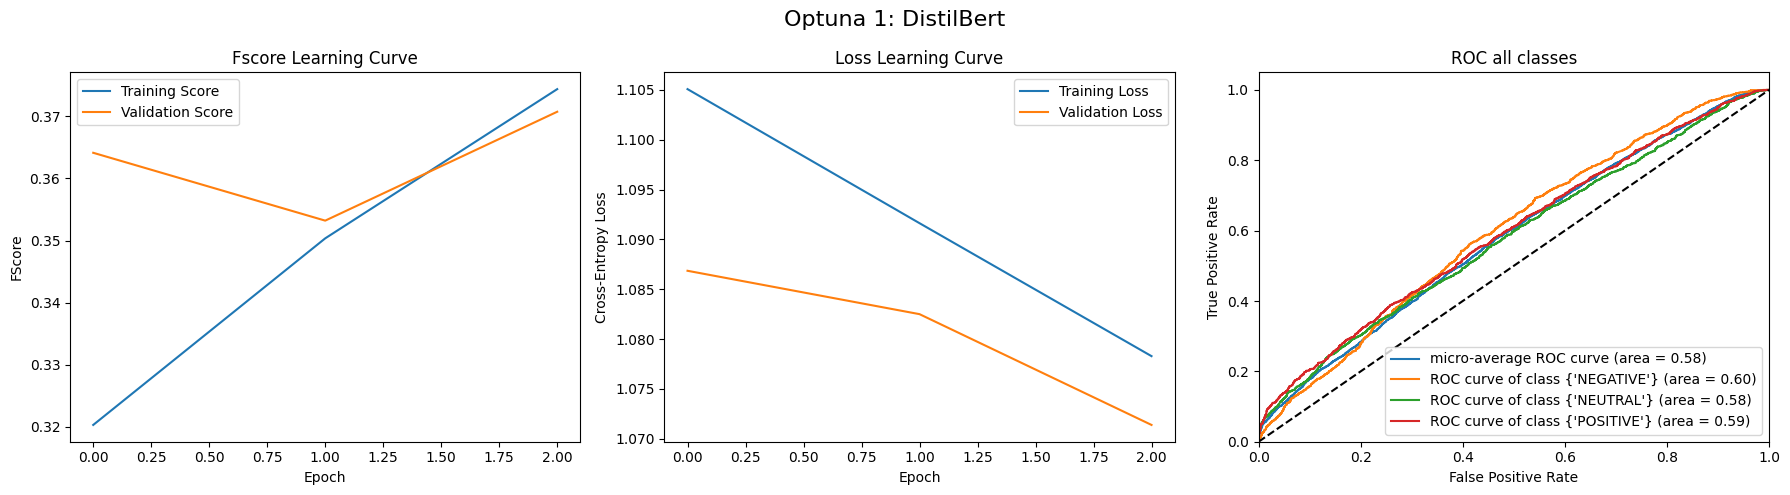

In [24]:
#learning_range = [2e-5, 5e-05]
#dropout_range  = [0, 0.5]
#bert           = False
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=40)
#best_params = study.best_params
#print(f"Best Hyperparameters: {best_params}")

#################################################################

dropout_n = 0.06362710211554035

distil_model = DistilBertDropout(n_classes=3, dropout=dropout_n)
distil_model.to(device)

num_epochs       = 3
learning_rate    = 4.2332715554961435e-05
clip_g           = True
criterion        = nn.CrossEntropyLoss()
optimizer        = torch.optim.AdamW(distil_model.parameters(), lr=learning_rate)
train_dataloader = train_dataloader_distil
val_dataloader   = val_dataloader_distil

# train model
tr_scores, tr_losses, val_scores, val_losses, epochs, distil_model = train_model(
    train_distil, validation_distil, distil_model, criterion, optimizer, batch_size, num_epochs, clip_g, train_dataloader_distil, val_dataloader_distil)

# show results
model_results(distil_model, x_tr_distil, y_train, x_val_distil, y_validation, epochs, tr_scores, val_scores, tr_losses, val_losses,
               "Optuna 1: DistilBert", train_dataloader_distil, val_dataloader_distil)

## **Run 2**

  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 1/3] Train Loss: 1.1081 / Validation Loss: 1.0932


  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 2/3] Train Loss: 1.0947 / Validation Loss: 1.0783


  0%|          | 0/733 [00:00<?, ?it/s]

[Epoch 3/3] Train Loss: 1.0807 / Validation Loss: 1.0653
Τraining set:

[Weighted average] Precision = 0.4420754110741547
[Weighted average] Recall    = 0.41624351624351613
[Weighted average] Fscore    = 0.38788362154351524

[NEGATIVE Class] Precision = 0.41054987212276217
[NEGATIVE Class] Recall = 0.5258804258804258
[NEGATIVE Class] Fscore = 0.4611131059245961

[NEUTRAL Class] Precision = 0.513960113960114
[NEUTRAL Class] Recall = 0.14774774774774774
[NEUTRAL Class] Fscore = 0.22951653944020353

[POSITIVE Class] Precision = 0.4017162471395881
[POSITIVE Class] Recall = 0.575102375102375
[POSITIVE Class] Fscore = 0.47302121926574603



Validation set:

[Weighted average] Precision = 0.4406315096540815
[Weighted average] Recall    = 0.41131498470948014
[Weighted average] Fscore    = 0.38445596188439946

[NEGATIVE Class] Precision = 0.4019873532068654
[NEGATIVE Class] Recall = 0.5103211009174312
[NEGATIVE Class] Fscore = 0.449722081859525

[NEUTRAL Class] Precision = 0.5227722772277228
[N

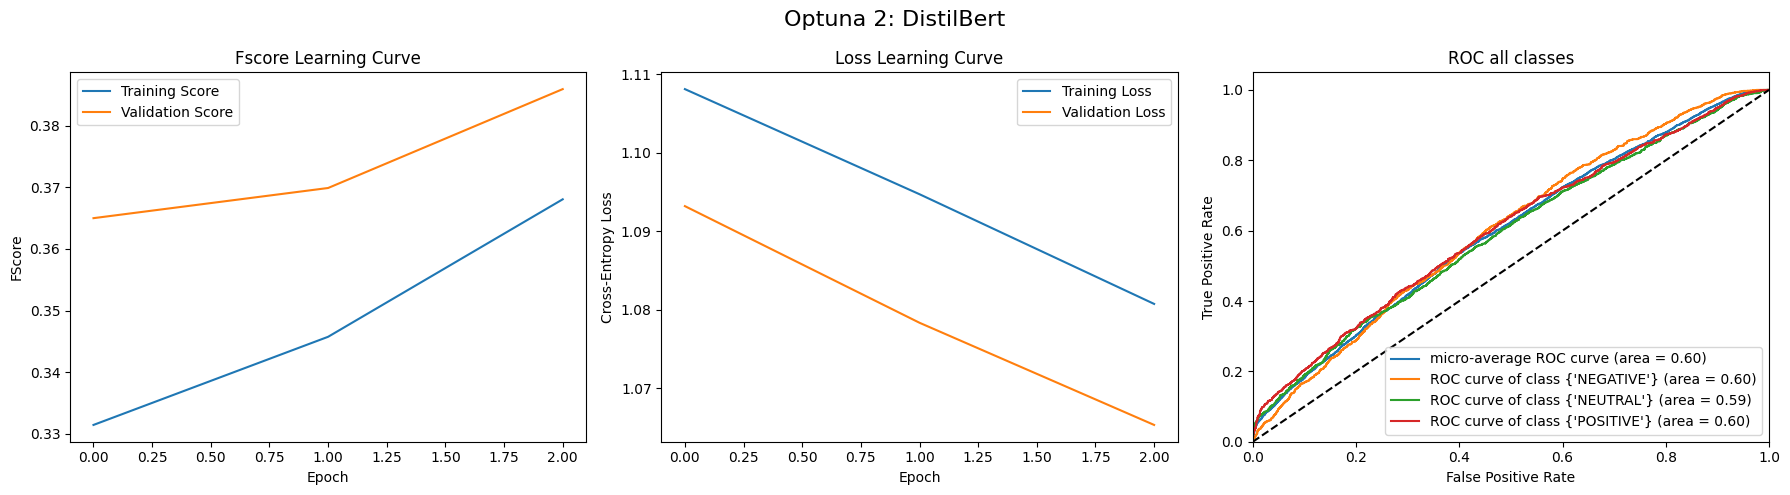

In [25]:
# after the first run I can not find any specific learning rate range
# and the best results occur for the dropout range are at [0.03, 0.13]

#learning_range = [3e-5, 5e-5]
#dropout_range  = [0.03, 0.13]
#bert           = False
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=40)
#best_params = study.best_params
#print(f"Best Hyperparameters: {best_params}")

#################################################################

dropout_n = 0.12821703534994192

distil_model = DistilBertDropout(n_classes=3, dropout=dropout_n)
distil_model.to(device)

num_epochs       = 3
learning_rate    = 4.3476920712742106e-05
clip_g           = True
criterion        = nn.CrossEntropyLoss()
optimizer        = torch.optim.AdamW(distil_model.parameters(), lr=learning_rate)
train_dataloader = train_dataloader_distil
val_dataloader   = val_dataloader_distil

# train model
tr_scores, tr_losses, val_scores, val_losses, epochs, distil_model = train_model(
    train_distil, validation_distil, distil_model, criterion, optimizer, batch_size, num_epochs, clip_g, train_dataloader_distil, val_dataloader_distil)

# show results
model_results(distil_model, x_tr_distil, y_train, x_val_distil, y_validation, epochs, tr_scores, val_scores, tr_losses, val_losses,
               "Optuna 2: DistilBert", train_dataloader_distil, val_dataloader_distil)

# **Final Models**
Finally, here I present my final models for Bert and DistilBert. Basically the models found by optuna.

Τraining set:

[Weighted average] Precision = 0.49248680850400184
[Weighted average] Recall    = 0.48891618891618893
[Weighted average] Fscore    = 0.48356755580531857

[NEGATIVE Class] Precision = 0.4952715288723313
[NEGATIVE Class] Recall = 0.5661752661752661
[NEGATIVE Class] Fscore = 0.5283552430449403

[NEUTRAL Class] Precision = 0.5138520838352204
[NEUTRAL Class] Recall = 0.3493857493857494
[NEUTRAL Class] Fscore = 0.41595163806552266

[POSITIVE Class] Precision = 0.4683368128044537
[POSITIVE Class] Recall = 0.5511875511875511
[POSITIVE Class] Fscore = 0.5063957863054929



Validation set:

[Weighted average] Precision = 0.4315181719858458
[Weighted average] Recall    = 0.4271788990825688
[Weighted average] Fscore    = 0.4220312415361992

[NEGATIVE Class] Precision = 0.4136919315403423
[NEGATIVE Class] Recall = 0.48509174311926606
[NEGATIVE Class] Fscore = 0.4465558194774347

[NEUTRAL Class] Precision = 0.45676855895196505
[NEUTRAL Class] Recall = 0.2998853211009174
[NEUTRAL Class

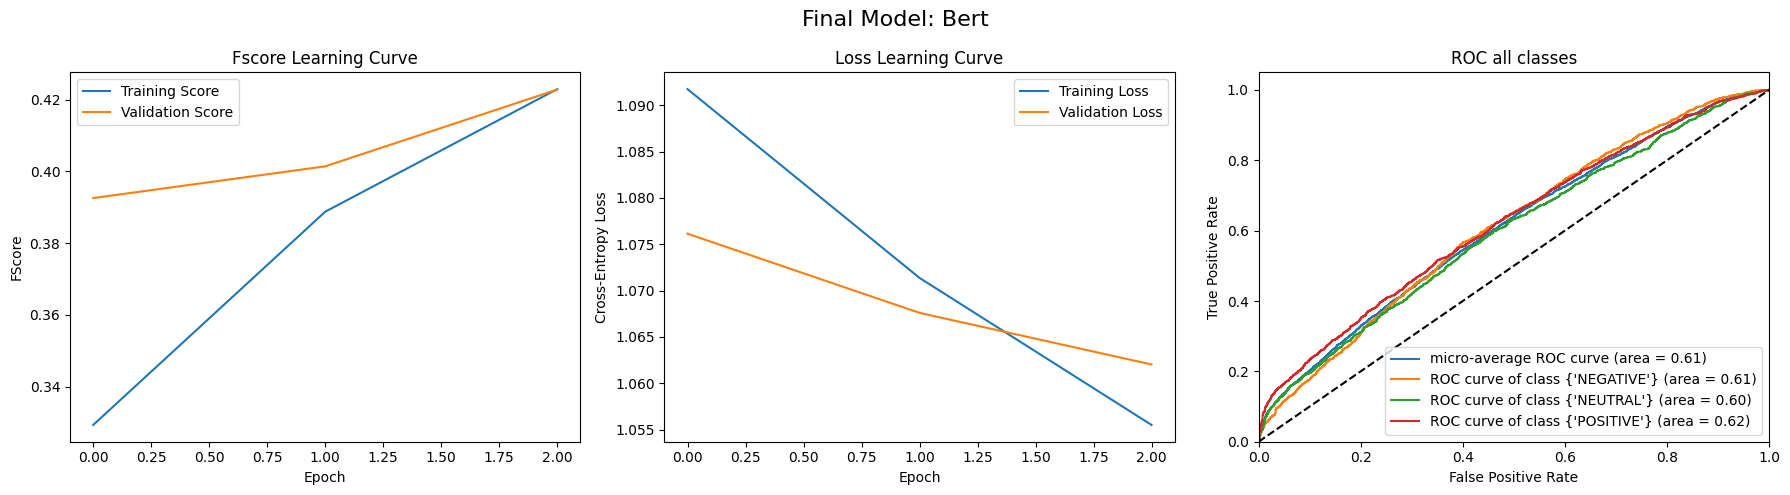

Τraining set:

[Weighted average] Precision = 0.4420754110741547
[Weighted average] Recall    = 0.41624351624351613
[Weighted average] Fscore    = 0.38788362154351524

[NEGATIVE Class] Precision = 0.41054987212276217
[NEGATIVE Class] Recall = 0.5258804258804258
[NEGATIVE Class] Fscore = 0.4611131059245961

[NEUTRAL Class] Precision = 0.513960113960114
[NEUTRAL Class] Recall = 0.14774774774774774
[NEUTRAL Class] Fscore = 0.22951653944020353

[POSITIVE Class] Precision = 0.4017162471395881
[POSITIVE Class] Recall = 0.575102375102375
[POSITIVE Class] Fscore = 0.47302121926574603



Validation set:

[Weighted average] Precision = 0.4406315096540815
[Weighted average] Recall    = 0.41131498470948014
[Weighted average] Fscore    = 0.38445596188439946

[NEGATIVE Class] Precision = 0.4019873532068654
[NEGATIVE Class] Recall = 0.5103211009174312
[NEGATIVE Class] Fscore = 0.449722081859525

[NEUTRAL Class] Precision = 0.5227722772277228
[NEUTRAL Class] Recall = 0.15137614678899083
[NEUTRAL Class

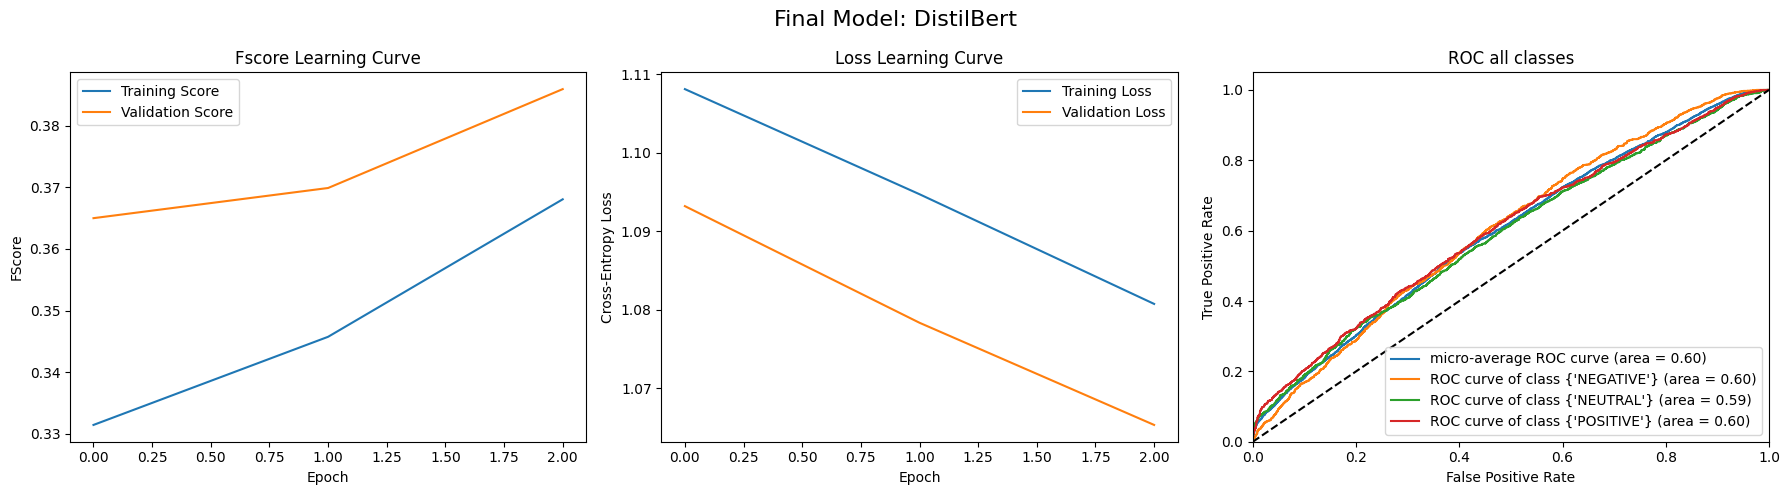

In [26]:
# final model for Bert
model_results(bert_model, x_tr_bert, y_train, x_val_bert, y_validation, epochs_b, tr_scores_b, val_scores_b, tr_losses_b, val_losses_b,
               "Final Model: Bert", train_dataloader_b, val_dataloader_b)

# final model for Distil Bert
model_results(distil_model, x_tr_distil, y_train, x_val_distil, y_validation, epochs, tr_scores, val_scores, tr_losses, val_losses,
               "Final Model: DistilBert", train_dataloader_distil, val_dataloader_distil)

# **Final Submission**

In [27]:
# get test data and preprocess it
test_df = pd.read_csv("/kaggle/input/ys19-2023-assignment-4a/test_set.csv") 
test_data = get_test_data(test_df)

train_sentences = [sentence for sentence in test_data['Text']]
label_mapping = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}

In [28]:
# make predictions using the bert model
y_pred = make_predictions(bert_model, train_sentences, tokenizer_b)

y_pred_tensor = torch.from_numpy(y_pred)

proba = F.softmax(y_pred_tensor, dim=1)
y_train_pred = torch.argmax(proba, dim=1)

y_train_pred_numpy = y_train_pred.numpy()

vectorized_mapping = np.vectorize(lambda x: label_mapping[x])
mapped_array = vectorized_mapping(y_train_pred_numpy)

final_df = pd.DataFrame({'Id': test_df['New_ID'], 'Predicted': mapped_array})
final_df.to_csv('output_file.csv', index=False)

In [29]:
# make predictions using the distil bert model
y_pred = make_predictions(distil_model, train_sentences, tokenizer_distil)

y_pred_tensor = torch.from_numpy(y_pred)

proba = F.softmax(y_pred_tensor, dim=1)
y_train_pred = torch.argmax(proba, dim=1)

y_train_pred_numpy = y_train_pred.numpy()

vectorized_mapping = np.vectorize(lambda x: label_mapping[x])
mapped_array = vectorized_mapping(y_train_pred_numpy)

final_df_distil = pd.DataFrame({'Id': test_df['New_ID'], 'Predicted': mapped_array})
final_df_distil.to_csv('output_file_distil.csv', index=False)